In [1]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [2]:
import torch
from torchvision import transforms
from torch.utils.data import DataLoader, Dataset
from sklearn.model_selection import train_test_split
from PIL import Image
import os

from torch.autograd import Variable
import matplotlib.pyplot as plt

In [3]:
# import os
# assert os.environ['COLAB_TPU_ADDR'], 'Make sure to select TPU from Edit > Notebook settings > Hardware accelerator'

In [4]:
# !pip install cloud-tpu-client==0.10 torch==2.0.0 torchvision==0.15.1 https://storage.googleapis.com/tpu-pytorch/wheels/colab/torch_xla-2.0-cp310-cp310-linux_x86_64.whl

In [5]:
is_cuda = torch.cuda.is_available()
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')


print('Current cuda device is', device)

Current cuda device is cuda


In [6]:
# imports the torch_xla package
# import torch_xla
# import torch_xla.core.xla_model as xm

In [7]:
# tpu 연습
# dev = xm.xla_device()


In [8]:

data_dir = '/content/drive/MyDrive/Deaplearning/d2l_notebooks/d2l-en/pytorch/D2L_assignment/training_dataset/tr/'
file_list = os.listdir(data_dir)  # 이미지 파일 리스트를 가져옵니다.
# 데이터 전처리 및 DataLoader 설정
transform = transforms.Compose([
    transforms.Resize((200, 200)),  # 이미지 크기 조정
    transforms.ToTensor(),           # 이미지를 텐서로 변환
    transforms.Normalize(mean=[0.5, 0.5, 0.5], std=[0.5, 0.5, 0.5])  # 이미지 정규화 (평균 0.5, 표준 편차 0.5)
])

class CustomDataset(Dataset):
    def __init__(self, file_list, transform=None):
        self.file_list = file_list
        self.transform = transform

    def __len__(self):
        return len(self.file_list)

    def __getitem__(self, idx):
        img_path = os.path.join(data_dir, self.file_list[idx])
        image = Image.open(img_path)
        age = int(self.file_list[idx].split("_")[0])  # 파일명에서 나이 정보 추출

        if self.transform:
            image = self.transform(image)

        return image, age

# 데이터 분할
train_files, val_files = train_test_split(file_list, test_size=0.2, random_state=42)

# DataLoader 설정
train_dataset = CustomDataset(train_files, transform=transform)
val_dataset = CustomDataset(val_files, transform=transform)
batch_size = 32
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=batch_size)

In [9]:
import torch.nn as nn

class AgePredictionModel(nn.Module):
    def __init__(self):
        super(AgePredictionModel, self).__init__()
        self.fc = nn.Linear(200 * 200 * 3, 1)  # 입력 이미지 크기에 맞는 Fully Connected 레이어

    def forward(self, x):
        x = x.view(x.size(0), -1)  # Flatten 작업
        x = self.fc(x)
        return x

model = AgePredictionModel()
model.to(device)


AgePredictionModel(
  (fc): Linear(in_features=120000, out_features=1, bias=True)
)

In [10]:
criterion = nn.MSELoss()
# optimizer = torch.optim.SGD(model.parameters(), lr=0.001, momentum=0.9)
optimizer = torch.optim.SGD(model.parameters(), lr=0.00001)

In [11]:
# Hyperparameter 설정
num_epochs = 10

# Learning Curve를 그리기 위한 리스트 초기화
train_losses = []
val_losses = []

In [12]:

for epoch in range(num_epochs):
    model.train()
    running_loss = 0.0
    for images, labels in train_loader:
        images , labels= images.to(device), labels.to(device)
        optimizer.zero_grad()
        outputs = model(images)
        loss = criterion(outputs.view(-1), labels.float())   # view 메소드 수정
        loss.backward()
        optimizer.step()
        running_loss += loss.item()

    # 훈련 손실 출력
    print(f"Epoch {epoch+1}/{num_epochs}, Training Loss: {running_loss/len(train_loader)}")
    # 훈련 손실 기록
    train_loss = running_loss / len(train_loader)
    train_losses.append(train_loss)
    # 검증 데이터셋에 대한 손실 계산
    model.eval()
    val_loss = 0.0
    with torch.no_grad():
        for images, labels in val_loader:
            images , labels= images.to(device), labels.to(device)
            outputs = model(images)
            loss = criterion(outputs.view(-1), labels.float())   # view 메소드 수정
            val_loss += loss.item()
     # 검증 손실 기록
    val_loss = val_loss / len(val_loader)
    val_losses.append(val_loss)

    # 에폭별로 손실 출력
    print(f"Epoch {epoch+1}/{num_epochs}, Validation Loss: {val_loss/len(val_loader)}")


Epoch 1/10, Training Loss: 171.1995773748918
Epoch 1/10, Validation Loss: 4.3018493372108875
Epoch 2/10, Training Loss: 128.01687963081127
Epoch 2/10, Validation Loss: 3.9042310478273503
Epoch 3/10, Training Loss: 116.58743904576157
Epoch 3/10, Validation Loss: 3.6114763412265414
Epoch 4/10, Training Loss: 112.01338195800781
Epoch 4/10, Validation Loss: 3.5623200191501305
Epoch 5/10, Training Loss: 107.90651595953739
Epoch 5/10, Validation Loss: 3.4134693968941905
Epoch 6/10, Training Loss: 104.97887319507021
Epoch 6/10, Validation Loss: 3.3278131195993135
Epoch 7/10, Training Loss: 102.34963419943145
Epoch 7/10, Validation Loss: 3.26638443651716
Epoch 8/10, Training Loss: 100.35700688217625
Epoch 8/10, Validation Loss: 3.2138924016330743
Epoch 9/10, Training Loss: 98.84270243211226
Epoch 9/10, Validation Loss: 3.163128995588879
Epoch 10/10, Training Loss: 98.03607958013362
Epoch 10/10, Validation Loss: 3.275305048274381


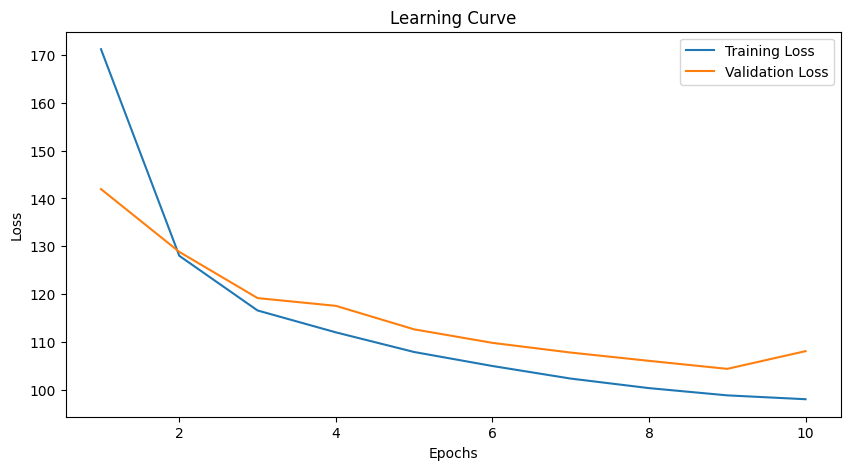

In [13]:
# Learning Curve 그리기
plt.figure(figsize=(10, 5))
plt.plot(range(1, num_epochs + 1), train_losses, label='Training Loss')
plt.plot(range(1, num_epochs + 1), val_losses, label='Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.title('Learning Curve')
plt.show()

In [14]:
print(train_losses)
print(val_losses)

[171.1995773748918, 128.01687963081127, 116.58743904576157, 112.01338195800781, 107.90651595953739, 104.97887319507021, 102.34963419943145, 100.35700688217625, 98.84270243211226, 98.03607958013362]
[141.96102812795928, 128.83962457830256, 119.17871926047586, 117.55656063195431, 112.64449009750828, 109.81783294677734, 107.79068640506628, 106.05844925389145, 104.383256854433, 108.08506659305456]


In [15]:
from torchsummary import summary



summary(model, input_size=(3,200,200), device='cuda')

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Linear-1                    [-1, 1]         120,001
Total params: 120,001
Trainable params: 120,001
Non-trainable params: 0
----------------------------------------------------------------
Input size (MB): 0.46
Forward/backward pass size (MB): 0.00
Params size (MB): 0.46
Estimated Total Size (MB): 0.92
----------------------------------------------------------------
